In [562]:
import numpy as np
from matplotlib import pyplot as plt

import snntorch as snn
from snntorch import spikegen
import snntorch.functional as SF

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model

In [563]:
dtype = torch.float

In [564]:
device = "cpu"

In [565]:
X_train = torch.Tensor(np.load("X_train.npy"))
y_train = torch.Tensor(np.load("y_train.npy"))

X_val = torch.Tensor(np.load("X_val.npy"))
y_val = torch.Tensor(np.load("y_val.npy"))

X_test = torch.Tensor(np.load("X_test.npy"))
y_test = torch.Tensor(np.load("y_test.npy"))

In [566]:
X_train = (X_train/255.0).type(torch.float32)
X_val = (X_val/255.0).type(torch.float32)
X_test = (X_test/255.0).type(torch.float32)

In [567]:
X_train.shape

torch.Size([6262, 28, 28])

In [568]:
y_train.shape

torch.Size([6262])

In [569]:
X_val.shape

torch.Size([783, 28, 28])

In [570]:
y_val.shape

torch.Size([783])

In [571]:
X_test.shape

torch.Size([19998, 28, 28])

In [572]:
y_test.shape

torch.Size([19998])

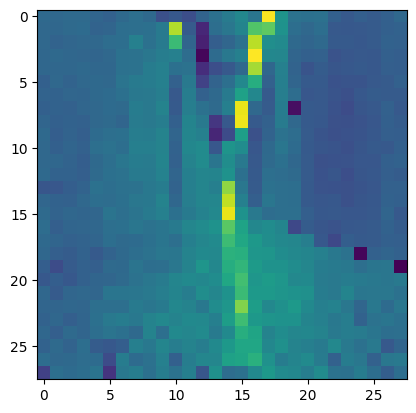

In [573]:
plt.imshow(X_train[0])

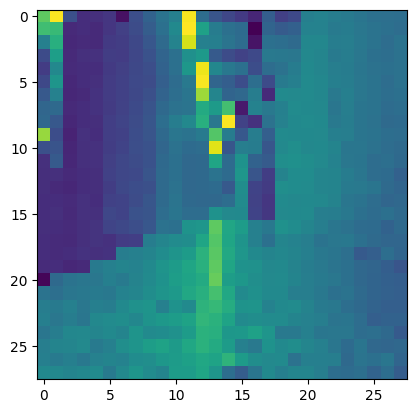

In [574]:
plt.imshow(X_val[0])

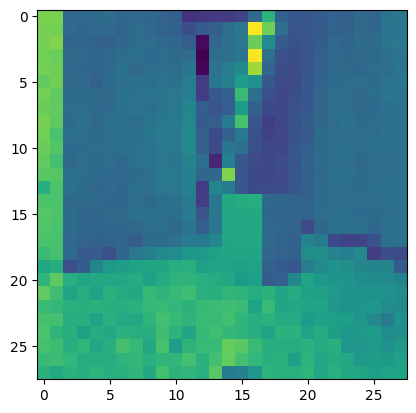

In [575]:
plt.imshow(X_test[1])

In [576]:
X_train = torch.reshape(X_train,(-1,784))
X_val = torch.reshape(X_val,(-1,784))
X_test = torch.reshape(X_test,(-1,784))

In [280]:
class SAE(nn.Module):
    def __init__(self,num_inputs,num_hidden,num_steps=25,beta=0.95):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_steps = num_steps
        self.beta = beta
        
        self.fc1 = nn.Linear(self.num_inputs,self.num_hidden)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(self.num_hidden, self.num_inputs)
        self.lif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [281]:
def train(model,train_dataloader,val_dataloader,epochs,loss_fn,optimizer):
    
    train_losses = []
    val_losses = []

    for e in range(epochs):
        train_batch = iter(train_dataloader)
    
        train_loss_epoch = 0
        val_loss_epoch = 0
    
        for data, targets in tqdm(train_batch):
            data = data.to(device)
            targets = targets.to(device)
        
            model.train()
            spk_rec, mem_rec = model(data.view(len(data), -1))

            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(model.num_steps):
                loss_val += loss_fn(mem_rec[step], targets)
                #spk_rec
        
            train_loss_epoch += loss_val.item()

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            with torch.no_grad():
                model.eval()
                val_data, val_targets = next(iter(val_dataloader))
                val_data = val_data.to(device)
                val_targets = val_targets.to(device)

                val_spk, val_mem = model(val_data.view(len(val_data), -1))

                val_loss = torch.zeros((1), dtype=dtype, device=device)
                for step in range(model.num_steps):
                    val_loss += loss_fn(val_mem[step], val_targets)
                    #val_spk
        
            val_loss_epoch += val_loss.item()
        
        print(f"Train loss at epoch: {e+1}: {train_loss_epoch}")
        print(f"Val loss at epoch: {e+1}: {val_loss_epoch}")
    
        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
    
    return train_losses,val_losses

In [282]:
BATCH_SIZE = 33
EPOCHS = 30
NUM_STEPS = 25

In [283]:
train_dataset = TensorDataset(X_train,X_train)
val_dataset = TensorDataset(X_val,X_val)

In [284]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [298]:
sae = SAE(784,300)

In [286]:
loss_fn = torch.nn.MSELoss()

In [299]:
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [300]:
train_losses,val_losses = train(sae,train_dataloader,val_dataloader,EPOCHS,loss_fn,optimizer)

  0%|                                                   | 0/190 [00:00<?, ?it/s]


TypeError: IncrementalLoss.forward() missing 1 required positional argument: 'model'

Text(0, 0.5, 'Loss')

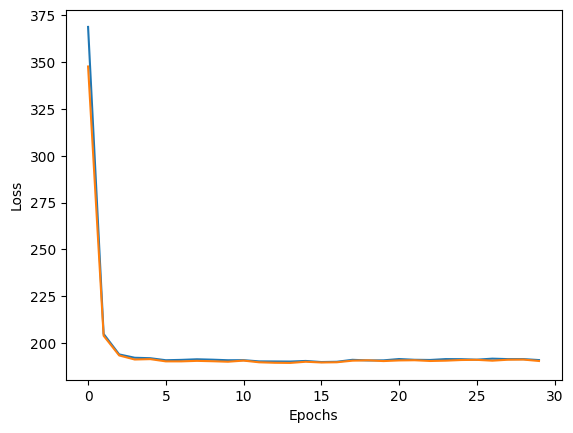

In [289]:
plt.plot(train_losses,label="Train loss")
plt.plot(val_losses,label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [290]:
sae.eval()
sample = X_train[0]
sample = torch.reshape(sample,(-1,784))
spk,mem = sae(sample)

In [291]:
mem.shape

torch.Size([25, 1, 784])

In [292]:
mem = torch.mean(mem,axis=0)
mem.shape

torch.Size([1, 784])

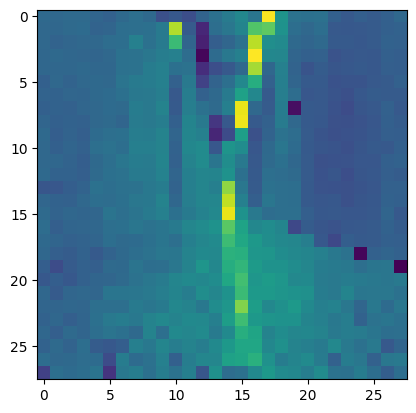

In [293]:
plt.imshow(sample.reshape(28,28))

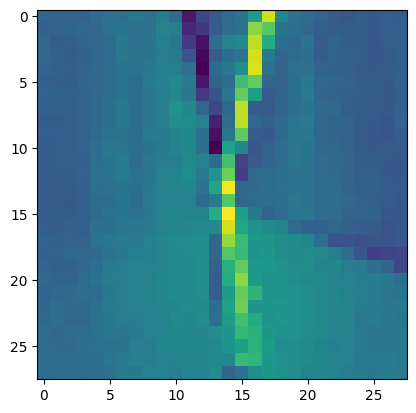

In [294]:
plt.imshow(mem.detach().numpy().reshape(28,28))

# Magic Loop Pazzo Sgravato

In [796]:
# Cose da attenzionare:

# 1) Normalizzazione del lambda ===> (Con lambda hanno stesso range)
# 2) Pre-allenamento su un gruppo normale (senza usare incremental) ====> Fatto
# 3) Possibilità di rendere dinamico l'hidden layer (Future works)
# 4) Valutazione FP, FN al variare threshold

In [797]:
class IncrementalLoss(nn.Module):
    def __init__(self, lambda_=0.1):
        super(IncrementalLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_ = lambda_
        self.previous_weights = None 

    def set_previous_weights(self, model):
        self.previous_weights = {name: param.clone().detach() for name, param in model.named_parameters()}

    def forward(self, predictions, targets, model):
 
        loss_mse = self.mse(predictions, targets)

        if self.previous_weights is None:
            return loss_mse

        weight_penalty = 0.0
        for name, param in model.named_parameters():
            if name in self.previous_weights:
                weight_penalty += torch.sum((param - self.previous_weights[name]) ** 2)

        #print("Penalty: ", weight_penalty)
        #print("MSE: ",loss_mse)
    
        total_loss = loss_mse + self.lambda_ * weight_penalty
        return total_loss

In [798]:
def magic_train(model,train_dataloader,val_dataloader,epochs,loss_fn,optimizer):
    
    train_losses = []

    for e in range(epochs):
        train_batch = iter(train_dataloader)
    
        train_loss_epoch = 0
        val_loss_epoch = 0
    
        for data, targets in tqdm(train_batch):
            data = data.to(device)
            targets = targets.to(device)
        
            model.train()
            spk_rec, mem_rec = model(data.view(len(data), -1))

            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(model.num_steps):
                loss_val += loss_fn(mem_rec[step], targets, model)
        
            train_loss_epoch += loss_val.item()

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
        
        #print(f"Train loss at epoch: {e+1}: {train_loss_epoch}")
    
        train_losses.append(train_loss_epoch)
    
    return train_losses

In [799]:
def compute_reconstruction_error(model,sample):
    spk,mem = model(sample)
    mem = torch.mean(mem,axis=0)
    mse = torch.nn.MSELoss()
    return mse(sample,mem).item()

In [800]:
BATCH_SIZE = 32
PRE_TRAIN_EPOCHS = 1
EPOCHS_PER_FRAME = 5

In [801]:
magic_sae = SAE(784,300,num_steps=25)

In [802]:
magic_cnn = load_model("AD_Loop_base.keras")

In [803]:
optimizer = torch.optim.Adam(magic_sae.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [804]:
X_pre_train = X_train[0:len(X_train)//2]

In [805]:
X = np.concatenate((X_train[len(X_train)//2:],X_test))

In [806]:
y = np.concatenate((y_train[len(X_train)//2:],y_test))

# Magic-SAE Pre-training

In [807]:
pre_train_dataset = TensorDataset(X_pre_train,X_pre_train)
pre_train_dataloader = DataLoader(pre_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
loss_fn = torch.nn.MSELoss()
train(magic_sae,pre_train_dataloader,pre_train_dataloader,PRE_TRAIN_EPOCHS,loss_fn,optimizer)

100%|███████████████████████████████████████████| 98/98 [00:02<00:00, 37.02it/s]

Train loss at epoch: 1: 234.06772756576538
Val loss at epoch: 1: 213.43028938770294


([234.06772756576538], [213.43028938770294])

# Threshold definition

In [808]:
magic_sae.eval()
spk,mem = magic_sae(X_pre_train)
mem = torch.mean(mem,axis=0)
mse = torch.nn.MSELoss()
THR = mse(X_pre_train,mem)
THR

tensor(0.0226, grad_fn=<MseLossBackward0>)

In [809]:
loss_fn = IncrementalLoss(lambda_=0.1)

In [810]:
frame_errors = []
preds = []
FP = 0
FN = 0 

for frame in range(len(X)):
    
    sample = torch.Tensor(X[frame])
    sample = torch.reshape(sample,(-1,784))
    frame_err = compute_reconstruction_error(magic_sae,sample)
    frame_errors.append(frame_err)
    
    
    if frame_err > THR*2:
        
        preds.append(1)
        
        # TO-DO:
        # p = magic_cnn()
        #...
  
        if y[frame] == 0:
            FP += 1
        
            # Normal: We adapt the magic SAE
            print(f"Training on frame: {frame+1}")
            train_dataset = TensorDataset(sample,sample)
            train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False) 
            magic_train(magic_sae,train_dataloader,train_dataloader,EPOCHS_PER_FRAME,loss_fn,optimizer)
            loss_fn.set_previous_weights(magic_sae)
        else:
            # Anomaly: Nothing to do here, we recognized the anomaly
            pass
    else:
        
        if y[frame] == 1:
            FN += 1
            
        preds.append(0)

Training on frame: 56


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 56.66it/s]


Training on frame: 69


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.67it/s]


Training on frame: 104


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.32it/s]


Training on frame: 169


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.80it/s]


Training on frame: 198


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.78it/s]


Training on frame: 200


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.33it/s]


Training on frame: 227


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.21it/s]


Training on frame: 710


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.44it/s]


Training on frame: 22737


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.95it/s]


Training on frame: 22761


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.95it/s]


Training on frame: 22854


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.63it/s]


Training on frame: 23026


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.72it/s]


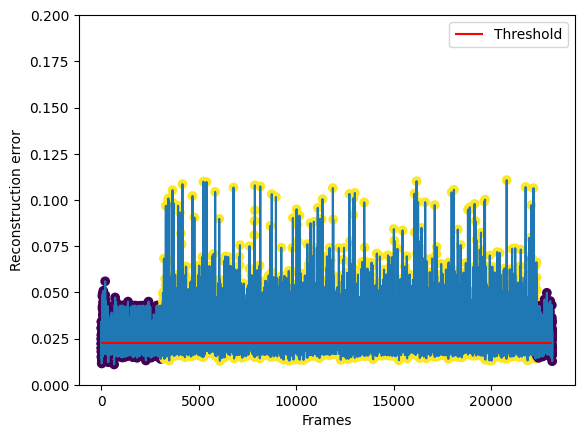

In [811]:
plt.plot(frame_errors)
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=y)
plt.hlines(y=THR.detach().numpy(),xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")

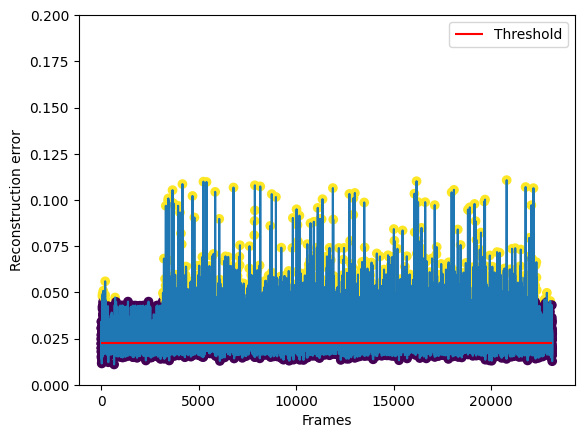

In [812]:
plt.plot(frame_errors)
plt.scatter(np.arange(len(frame_errors)),frame_errors,c=preds)
plt.hlines(y=THR.detach().numpy(),xmin=0,xmax=len(frame_errors),color="red",label="Threshold")
plt.xlabel("Frames")
plt.ylabel("Reconstruction error")
plt.ylim((0,0.2))
plt.legend(loc="best")

In [813]:
print("False Positives: ", FP)
print("False Negatives: ", FN)

False Positives:  12
False Negatives:  18072
